# Homework #7
---
Student Name: Sam Crane

Student ID: 801101091

GitHub: https://github.com/samofuture/Intro-to-ML

In [12]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
# use seaborn plotting defaults
import seaborn as sns; sns.set()
print(torch.cuda.device_count())
print(f"Version: {torch.__version__}, GPU: {torch.cuda.is_available()}, NUM_GPU: {torch.cuda.device_count()}")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1
Version: 2.1.1, GPU: True, NUM_GPU: 1


In [4]:
from torchvision import datasets, transforms
data_path = 'data-unversioned/p1ch7'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
to_tensor = transforms.ToTensor()

cifar10_tensor = datasets.CIFAR10(data_path, train=True, download=False, transform=to_tensor)

imgs = torch.stack([img_t for img_t, _ in cifar10_tensor], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

In [6]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

In [7]:
from sklearn import metrics

def validate(model, val_loader):
    num_correct = 0
    total_samples = 0
    predicted_classes = []
    val_outputs = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)

            _, predicted = torch.max(outputs, 1)
            num_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            predicted_classes.extend(predicted.cpu().numpy())
            val_outputs.extend(labels.cpu().numpy())

    accuracy = num_correct / total_samples
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    model.train()  # Set the model back to training mode

    # Display confusion matrix
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

    print(metrics.classification_report(val_outputs, predicted_classes))
    
    cnf_matrix = metrics.confusion_matrix(val_outputs, predicted_classes)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    # create heatmap
    sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g', xticklabels=class_names, yticklabels=class_names)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
        

## Problem 1a

In [7]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [8]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [37]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss().to(device)

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-10 12:16:45.620912 Epoch 1, Training loss 2.2800722706820316
2023-12-10 12:18:17.819029 Epoch 10, Training loss 1.8538836546784616
2023-12-10 12:20:00.183928 Epoch 20, Training loss 1.6116299738829163
2023-12-10 12:21:43.208025 Epoch 30, Training loss 1.4955438133400518
2023-12-10 12:23:26.574117 Epoch 40, Training loss 1.4137670386339969
2023-12-10 12:25:09.246841 Epoch 50, Training loss 1.3347787290697353
2023-12-10 12:26:50.439850 Epoch 60, Training loss 1.2716774278216891
2023-12-10 12:28:30.671552 Epoch 70, Training loss 1.2247503904547272
2023-12-10 12:30:12.619947 Epoch 80, Training loss 1.187387889600805
2023-12-10 12:31:53.613956 Epoch 90, Training loss 1.1561500838889929
2023-12-10 12:33:34.862204 Epoch 100, Training loss 1.1294020307018382
2023-12-10 12:35:16.495001 Epoch 110, Training loss 1.1035544072987933
2023-12-10 12:36:58.997716 Epoch 120, Training loss 1.0801695882132227
2023-12-10 12:38:40.268676 Epoch 130, Training loss 1.0570631013519463
2023-12-10 12:40:2

Validation Accuracy: 69.81%
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      5000
           1       0.80      0.82      0.81      5000
           2       0.61      0.56      0.59      5000
           3       0.53      0.49      0.51      5000
           4       0.64      0.65      0.65      5000
           5       0.60      0.58      0.59      5000
           6       0.75      0.77      0.76      5000
           7       0.71      0.74      0.73      5000
           8       0.79      0.82      0.80      5000
           9       0.78      0.81      0.79      5000

    accuracy                           0.70     50000
   macro avg       0.69      0.70      0.70     50000
weighted avg       0.69      0.70      0.70     50000



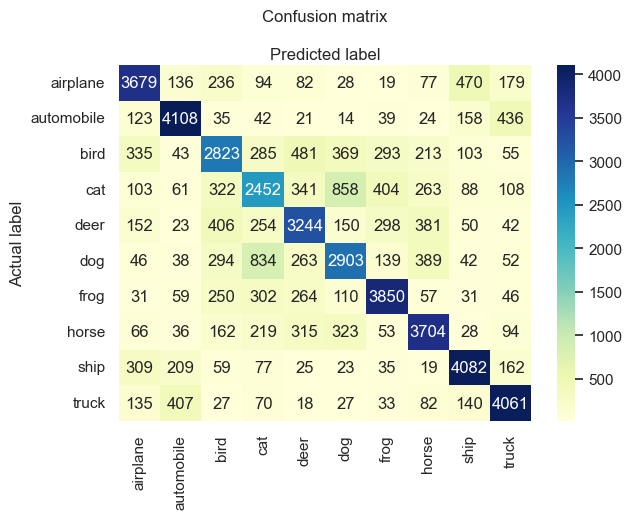

In [39]:

val_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

validate(model, val_loader)

Training Time: 51 minutes, 5.58 seconds

Training Loss: 0.869

Evaluation Accuracy: 69.81%

## Problem 1b

In [67]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(8)
        self.fc1 = nn.Linear(8 * 8 * 2, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = self.bn1(F.max_pool2d(torch.tanh(self.conv1(x)), 2))
        out = self.bn2(F.max_pool2d(torch.tanh(self.conv2(out)), 2))
        out = self.bn3(F.max_pool2d(torch.tanh(self.conv3(out)), 2))
        out = out.view(-1, 8 * 8 * 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [70]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

model_1b = Net().to(device)
optimizer = optim.SGD(model_1b.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss().to(device)

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model_1b,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-10 13:42:12.101521 Epoch 1, Training loss 2.163002387773945
2023-12-10 13:43:54.063801 Epoch 10, Training loss 1.4723345959323577
2023-12-10 13:45:50.843979 Epoch 20, Training loss 1.2498445803178224
2023-12-10 13:47:42.869608 Epoch 30, Training loss 1.1252093109591255
2023-12-10 13:49:33.449538 Epoch 40, Training loss 1.050079665421526
2023-12-10 13:51:23.933147 Epoch 50, Training loss 0.9947156506479928
2023-12-10 13:53:14.776828 Epoch 60, Training loss 0.9534578832629996
2023-12-10 13:55:08.507470 Epoch 70, Training loss 0.9205638309548184
2023-12-10 13:56:59.789920 Epoch 80, Training loss 0.8932963598276921
2023-12-10 13:58:52.254842 Epoch 90, Training loss 0.870658990295454
2023-12-10 14:00:54.195207 Epoch 100, Training loss 0.8476989725997165
2023-12-10 14:02:46.249325 Epoch 110, Training loss 0.8314227299671977
2023-12-10 14:04:37.100583 Epoch 120, Training loss 0.8168435192656243
2023-12-10 14:06:27.721547 Epoch 130, Training loss 0.8009732817781383
2023-12-10 14:08:20.

Validation Accuracy: 76.18%
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      5000
           1       0.86      0.91      0.88      5000
           2       0.70      0.61      0.65      5000
           3       0.63      0.56      0.59      5000
           4       0.67      0.75      0.71      5000
           5       0.66      0.68      0.67      5000
           6       0.83      0.78      0.80      5000
           7       0.75      0.83      0.79      5000
           8       0.85      0.87      0.86      5000
           9       0.87      0.84      0.86      5000

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



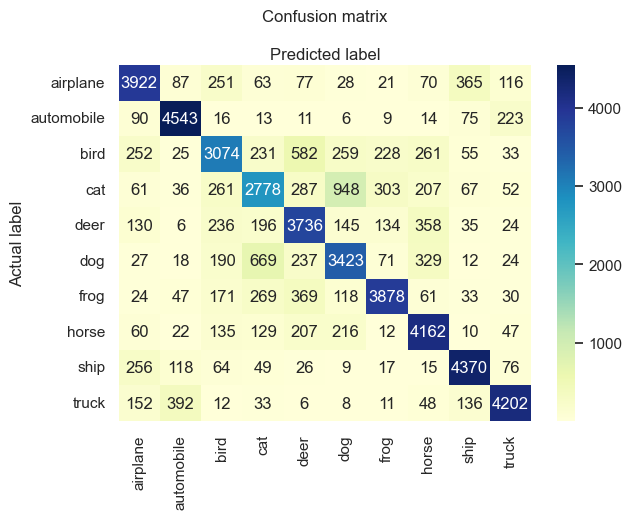

In [71]:
val_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

validate(model_1b, val_loader)

Training Time: 55 minutes, 55.75 seconds

Training Loss: 0.677

Evaluation Accuracy: 76.18%

This is a more accurate model than the one in problem 1a. It has a greater recall and f1 score than the previous one and doesn't show signs of overfitting yet.

## Problem 2a

In [10]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 *self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [22]:
class ResBlock(nn.Module):
    def __init__(self, n_chans) -> None:
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [14]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

resnet_10 = NetResDeep(n_chans1=32, n_blocks=10).to(device)
optimizer = optim.SGD(resnet_10.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = resnet_10,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(resnet_10, val_loader)

2023-12-10 15:49:12.492795 Epoch 1, Training loss 1.6834016468213953
2023-12-10 15:51:34.691693 Epoch 10, Training loss 0.8968138417319569
2023-12-10 15:54:13.789540 Epoch 20, Training loss 0.7042019813109541
2023-12-10 15:56:56.660801 Epoch 30, Training loss 0.5857076307811091
2023-12-10 15:59:34.370668 Epoch 40, Training loss 0.48426527261276686
2023-12-10 16:02:10.906362 Epoch 50, Training loss 0.39646135175319586
2023-12-10 16:04:47.654248 Epoch 60, Training loss 0.32335674425448907
2023-12-10 16:07:24.202439 Epoch 70, Training loss 0.2630850438438261
2023-12-10 16:10:00.646803 Epoch 80, Training loss 0.20801323173029343
2023-12-10 16:12:37.061407 Epoch 90, Training loss 0.16741775050568763
2023-12-10 16:15:17.151805 Epoch 100, Training loss 0.1386275638128295
2023-12-10 16:17:58.817010 Epoch 110, Training loss 0.11575714836154333
2023-12-10 16:20:39.229646 Epoch 120, Training loss 0.10169824309375547
2023-12-10 16:23:20.202146 Epoch 130, Training loss 0.07986598953877426
2023-12-1

NameError: name 'val_loader' is not defined

Validation Accuracy: 15.67%
              precision    recall  f1-score   support

           0       0.61      0.08      0.14      5000
           1       0.94      0.01      0.01      5000
           2       0.33      0.07      0.12      5000
           3       0.51      0.01      0.02      5000
           4       0.11      0.99      0.20      5000
           5       0.68      0.01      0.02      5000
           6       0.65      0.12      0.21      5000
           7       0.56      0.04      0.07      5000
           8       0.68      0.20      0.31      5000
           9       0.53      0.03      0.05      5000

    accuracy                           0.16     50000
   macro avg       0.56      0.16      0.12     50000
weighted avg       0.56      0.16      0.12     50000



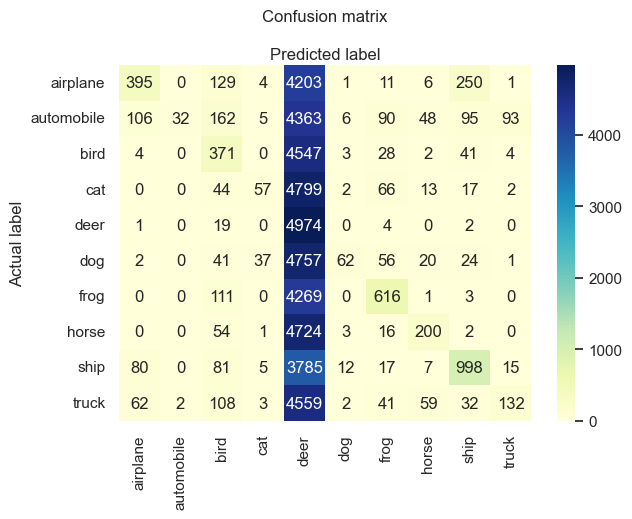

In [15]:
val_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

validate(resnet_10, val_loader)

Training Time: 1 hour, 19 minutes, 32.99 seconds

Training Loss: 0.0018

Evaluation Accuracy: 15.67%

While the Training Time is mostly the same, taking a little longer to train, and the training loss is significantly lower, the evaluation accuracy is terrible in comparison. It is likely that overfitting occurred on this model.

## Problem 2b

### Weight Decay

In [23]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=192, shuffle=True)

resnet_10_wd = NetResDeep(n_chans1=32, n_blocks=10).to(device)
optimizer = optim.SGD(resnet_10_wd.parameters(), lr=3e-3, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = resnet_10_wd,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(resnet_10, val_loader)

2023-12-10 18:43:03.216041 Epoch 1, Training loss 1.7765525972751706
2023-12-10 18:45:06.538873 Epoch 10, Training loss 1.0214598331305071
2023-12-10 18:47:21.651924 Epoch 20, Training loss 0.818818483968525
2023-12-10 18:49:39.334349 Epoch 30, Training loss 0.7051090508165871
2023-12-10 18:51:59.728299 Epoch 40, Training loss 0.6152353790562476
2023-12-10 18:54:19.892220 Epoch 50, Training loss 0.5352421681899244
2023-12-10 18:56:38.019755 Epoch 60, Training loss 0.4766648516173253
2023-12-10 18:58:56.846716 Epoch 70, Training loss 0.4156135369063643
2023-12-10 19:01:17.536408 Epoch 80, Training loss 0.36191229392652924
2023-12-10 19:03:35.211513 Epoch 90, Training loss 0.31945943165465696
2023-12-10 19:05:53.619812 Epoch 100, Training loss 0.27737614125623117
2023-12-10 19:08:10.831009 Epoch 110, Training loss 0.23444547191681459
2023-12-10 19:10:27.703962 Epoch 120, Training loss 0.19753117857458036
2023-12-10 19:12:42.114723 Epoch 130, Training loss 0.15666856460482873
2023-12-10 1

Training Time: 

Training Loss: 

Evaluation Accuracy: 

### Dropout

In [20]:
class ResBlock(nn.Module):
    def __init__(self, n_chans, dropout_prob=0.3) -> None:
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        self.dropout = nn.Dropout(p=dropout_prob)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        out = self.dropout(out)
        return out + x



In [21]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=192, shuffle=True)

resnet_10_d = NetResDeep(n_chans1=32, n_blocks=10).to(device)
optimizer = optim.SGD(resnet_10_d.parameters(), lr=3e-3, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = resnet_10_d,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(resnet_10, val_loader)

2023-12-10 18:35:54.387097 Epoch 1, Training loss nan
2023-12-10 18:37:57.482488 Epoch 10, Training loss nan


KeyboardInterrupt: 

Training Time: 

Training Loss: 

Evaluation Accuracy: 

### Batch Normalization

In [16]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, n_chans) -> None:
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')

    def forward(self, x):
        out = self.conv(x)
        out = torch.relu(out)
        return out + x

2023-12-10 17:23:00.092762 Epoch 1, Training loss nan
2023-12-10 17:24:58.248383 Epoch 10, Training loss nan
2023-12-10 17:27:10.312914 Epoch 20, Training loss nan
2023-12-10 17:29:23.310202 Epoch 30, Training loss nan
2023-12-10 17:31:35.206018 Epoch 40, Training loss nan
2023-12-10 17:33:46.440316 Epoch 50, Training loss nan
2023-12-10 17:36:02.478339 Epoch 60, Training loss nan
2023-12-10 17:38:17.522647 Epoch 70, Training loss nan
2023-12-10 17:40:33.879337 Epoch 80, Training loss nan
2023-12-10 17:42:44.220933 Epoch 90, Training loss nan
2023-12-10 17:44:57.484956 Epoch 100, Training loss nan
2023-12-10 17:47:12.899700 Epoch 110, Training loss nan
2023-12-10 17:49:29.033819 Epoch 120, Training loss nan
2023-12-10 17:51:43.863488 Epoch 130, Training loss nan
2023-12-10 17:54:00.112675 Epoch 140, Training loss nan
2023-12-10 17:56:17.195340 Epoch 150, Training loss nan
2023-12-10 17:58:34.205246 Epoch 160, Training loss nan
2023-12-10 18:00:52.028957 Epoch 170, Training loss nan
202

c:\Users\Sam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


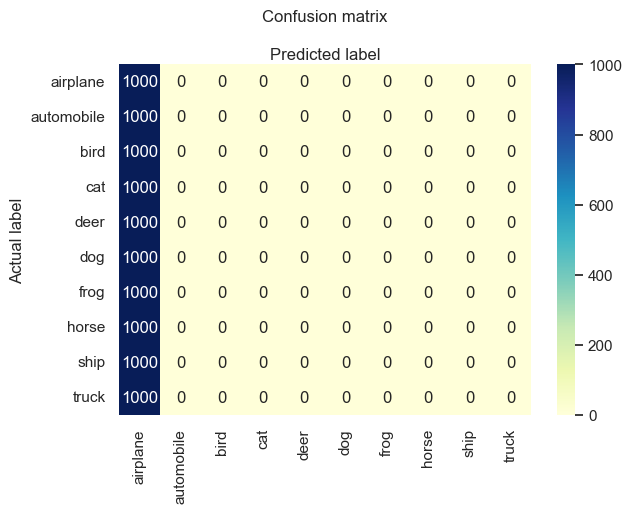

In [18]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=192, shuffle=True)

resnet_10 = NetResDeep(n_chans1=32, n_blocks=10).to(device)
optimizer = optim.SGD(resnet_10.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = resnet_10,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(resnet_10, val_loader)

Training Time: 53 minutes, and 41.99 seconds

Training Loss: nan (basically infinity)

Evaluation Accuracy: 10%

It is likely here that the lack of normalization caused the resblocks to fail in their purpose of training the model.